# CNN trained on cactus data

## Adapted from DSCI 572 Lab 4

In [37]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d

from skimage.io import imread
import re
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import json
from collections import defaultdict
from tqdm import tqdm
import pickle
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from itertools import chain
from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [38]:
plt.rcParams['font.size'] = 16

## Getting image paths and labels

In [39]:
root_path = "../data/"

In [92]:
def get_img_paths():
    """
    Returns img paths for cactus dataset

    --------
    list, list, list, list: 
        training image paths, testing image paths, training classes, testing classes
    """
    train_img_path = []
    train_img_class = []
    test_img_path = []
    test_img_class = []
    for root, dirs, files in os.walk(os.path.abspath(root_path + "training_set/training_set/no_cactus")):
        for file in files:
            train_img_path.append(file)
            train_img_class.append("no_cactus")
    for root, dirs, files in os.walk(os.path.abspath(root_path + "training_set/training_set/cactus")):
        for file in files:
            train_img_path.append(file)
            train_img_class.append("cactus")
    for root, dirs, files in os.walk(os.path.abspath(root_path + "validation_set/validation_set/no_cactus")):
        for file in files:
            test_img_path.append(file)
            test_img_class.append("no_cactus")
    for root, dirs, files in os.walk(os.path.abspath(root_path + "validation_set/validation_set/cactus")):
        for file in files:
            test_img_path.append(file)
            test_img_class.append("cactus")
    return train_img_path, test_img_path, train_img_class, test_img_class


In [93]:
len(get_img_paths()[0])

17500

In [94]:
len(get_img_paths()[1])

4000

In [95]:
train_path, test_path, train_class, test_class = get_img_paths()

In [96]:
train_path[1]

'Sinplanta.3141.jpg'

In [97]:
train_class[1]

'no_cactus'

In [104]:
print(len(train_class))
print(len(set(train_class)))

17500
2


In [108]:
labels = set(train_class)
labels

{'cactus', 'no_cactus'}

In [109]:
d = dict()
i = 0
for label in labels:
    if label not in d:
        d[label] = i
        i += 1
print(d)

{'cactus': 0, 'no_cactus': 1}


## Training baseline model with 1 color channel

In [165]:
train_img = []
y_train = []
train_length = 3000 #len(train_path)
for i in range(0, train_length):
    # defining the image path
    if(train_class[i] == "cactus"):
        image_path = root_path + "training_set/training_set/cactus/" + train_path[i]
    else:
        image_path = root_path + "training_set/training_set/no_cactus/" + train_path[i]
    # reading the image
    img = imread(root_path + image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)
    y_train.append(train_class[i])
    
# converting the list to numpy array
X_train = np.array(train_img)
# defining the target
X_train.shape
y_train = np.array(y_train)
for i in range(0, len(y_train)):
    y_train[i] = d[y_train[i]]
y_train = y_train.astype(int);
print(X_train.shape)
print(y_train.shape)

(3000, 32, 32)
(3000,)


In [166]:
test_img = []
y_test = []
test_length = 1000 #len(test_path)
for i in range(0, test_length):
    # defining the image path
    if(test_class[i] == "cactus"):
        image_path = root_path + "validation_set/validation_set/cactus/" + test_path[i]
    else:
        image_path = root_path + "validation_set/validation_set/no_cactus/" + test_path[i]
    # reading the image
    img = imread(root_path + image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)
    y_test.append(test_class[i])
    
# converting the list to numpy array
X_test = np.array(test_img)
# defining the target
X_test.shape
y_test = np.array(y_test)
for i in range(0, len(y_test)):
    y_test[i] = d[y_test[i]]
y_test = y_test.astype(int);
print(X_test.shape)
print(y_test.shape)

(1000, 32, 32)
(1000,)


In [167]:
# reshape to be [samples][channels][width][height]
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1).astype('float32')

# one hot encode outputs
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(num_classes)

(3000, 32, 32, 1)
(3000, 2)
(1000, 32, 32, 1)
(1000, 2)
2


In [168]:
combined = list(zip(X_train, y_train))
random.shuffle(combined)

X_train[:], y_train[:] = zip(*combined)

combined = list(zip(X_test, y_test))
random.shuffle(combined)

X_test[:], y_test[:] = zip(*combined)

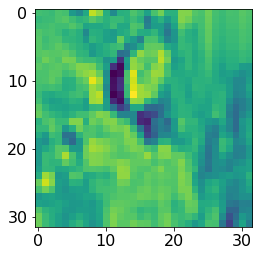

In [169]:
plt.imshow(X_train[0].reshape([32,32]))

In [170]:
# define a simple CNN model
def build_mnist_CNN():
    mnist_model = Sequential()
    mnist_model.add(Conv2D(32, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
    mnist_model.add(Dropout(0.2))
    mnist_model.add(Flatten())
    mnist_model.add(Dense(128, activation='relu'))
    mnist_model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    mnist_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return mnist_model

In [171]:
mnist_model = build_mnist_CNN()

In [172]:
# Fit the model
mnist_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=256)
# Final evaluation of the model
scores = mnist_model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
12/12 [==============================] - 1s 84ms/step - loss: 0.3968 - accuracy: 0.9997 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 1s 78ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 3.0953e-05 - val_accuracy: 1.0000
Epoch 3/10
12/12 [==============================] - 1s 76ms/step - loss: 9.0255e-06 - accuracy: 1.0000 - val_loss: 1.2664e-06 - val_accuracy: 1.0000
Epoch 4/10
12/12 [==============================] - 1s 77ms/step - loss: 7.2662e-07 - accuracy: 1.0000 - val_loss: 3.9470e-07 - val_accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 1s 77ms/step - loss: 3.2504e-07 - accuracy: 1.0000 - val_loss: 2.6321e-07 - val_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 1s 80ms/step - loss: 2.5761e-07 - accuracy: 1.0000 - val_loss: 2.4664e-07 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 1s 82ms/step - loss: 2.3921e-07 - accuracy: 1.0000 - val_loss: 2.4

> This dataset with 2 classes is simple enough that a shallow CNN can achieve 100% validation accuracy almost immediately.